### Import Library

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import itertools
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
X = pd.read_csv('dataset/fitur.csv').values
X

array([[0.31872071, 0.72571429, 0.7885906 , 0.29581065],
       [0.43865454, 0.58539683, 0.80033557, 0.43501567],
       [0.27488282, 0.60888889, 0.8590604 , 0.38042223],
       ...,
       [0.30576234, 0.4984127 , 0.26510067, 0.14052449],
       [0.28205128, 0.33777778, 0.38590604, 0.06828303],
       [0.54921423, 0.83936508, 0.68120805, 0.80851064]])

In [3]:
y = pd.read_csv('dataset/target.csv').values
y

array([[0.49580396],
       [0.56562605],
       [0.50855992],
       ...,
       [0.224572  ],
       [0.14837194],
       [0.78549849]])

### Split Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Modeling

##### Inisialisasi bobot dan bias

In [5]:
def inisialisasi(hidden_layer, hidden_neuron):
    bobot = []
    bias = []
    for i in range(hidden_layer):
        if i == 0:
            bobot.append(np.random.rand(4, hidden_neuron[i]).tolist())
        else:
            bobot.append(np.random.rand(hidden_neuron[i-1], hidden_neuron[i]).tolist())
        bias.append(np.random.rand(hidden_neuron[i]).tolist())
    bobot_output = np.random.rand(hidden_neuron[-1]).tolist()
    bias_output = np.random.rand()
    return bobot, bias, bobot_output, bias_output

##### Fungsi aktivasi

In [6]:
def relu(x):
    if x > 0:
        return x
    else:
        return 0

def turunan_relu(x):
    if x > 0:
        return 1
    else:
        return 0 

##### Fungsi Training

In [7]:
def ann(epochs, hidden_layer, hidden_neuron, lr, X_train, y_train):
    bobot, bias, bobot_output, bias_output = inisialisasi(hidden_layer, hidden_neuron)
    best_mse = float('inf')
    best_bobot = bobot
    best_bias = bias
    best_bobot_output = bobot_output
    best_bias_output = bias_output
    for epoch in range(epochs):
        total_error = 0
        for i in range(len(X_train)):
            # FEEDFORWARD
            # Operasi pada Hidden Layer
            # penjumlahan terbobot dan aktivasi
            aktivasi_hidden = [] # menampung keseluruhan aktivasi
            for j in range(hidden_layer):
                aktivasi_hidden_temp = [] # menampung aktivasi setiap hiden layer (sementara)
                for k in range(hidden_neuron[j]):
                    sumXbobot = 0 # hasil penjumlahan terbobot
                    if j == 0: # untuk hidden neuron pertama (karena neuron input tidak terdefinisi)
                        for l in range(4): # jumlah neuron layer sebelumnya/ neuron input = 4
                            sumXbobot += bobot[j][l][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]): # jumlah neuron layer sebelumnya
                            sumXbobot += bobot[j][l][k] * aktivasi_hidden[j-1][l]
                    # menambahkan bias pada hasil penjumlahan terbobot
                    sumXbobotbias = bias[j][k] + sumXbobot
                    # aktivasi
                    aktivasi_hidden_temp.append(relu(sumXbobotbias))
                # menambahkan hasil aktivasi tiap hidden_layer ke penampung keseluruhan
                aktivasi_hidden.append(aktivasi_hidden_temp)

            # Operasi pada Output Layer
            # perkalian
            sumZbobotoutput = 0 # hasil penjumlahan terbobot di output layer
            for j in range(hidden_neuron[-1]):
                sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
            # menambahkan bias pada hasil penjumlahan terbobot di output layer
            sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
            # aktivasi
            prediksi = relu(sumZbobotoutput_biasoutput)

            # Hitung Error (total error untuk menghitung MSE)
            error = y_train[i][0] - prediksi
            total_error += (error ** 2)

        # BACKPROPAGATION
        # error output layer
        error_output = error * turunan_relu(prediksi)
        # inisialisasi error setiap neuron di hidden layer
        error_nuron_hidden = []
        for i in range(hidden_layer):
            error_nuron_hidden.append(np.zeros(hidden_neuron[i]).tolist())
        # error setiap neuron di hidden layer
        for i in range(hidden_layer):
            for j in range(hidden_neuron[-(i+1)]): # mulai dari hidden layer terakhir
                if i == 0: # hidden terakhir akan melibatkan error output
                    sumErrorBobotSetelah = 0
                    sumErrorBobotSetelah += error_output * bobot_output[j]
                    # sum dikalikan turunan input
                    error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunan_relu(aktivasi_hidden[-(i+1)][j]) 
                else:
                    sumErrorBobotSetelah = 0
                    for k in range(hidden_neuron[-(i)]): # hidden layer yang 1 lebihnya
                        sumErrorBobotSetelah += error_nuron_hidden[-(i)][k] * bobot[-(i)][j][k]
                        # sum dikalikan turunan input
                        error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunan_relu(aktivasi_hidden[-(i+1)][j]) 
        # memperbaiki bobot dan bias
        for i in range(len(X_train)):
            for j in range(hidden_layer):
                for k in range(hidden_neuron[j]):
                    # memperbaiki bobot
                    if j == 0:
                        for l in range(4):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * aktivasi_hidden[j-1][l]
                # memperbaiki bias
                bias[j][k] += lr * error_nuron_hidden[j][k]
        # memperbaiki bobot output
        for i in range(len(bobot_output)):
            bobot_output[i] += lr * error_output * aktivasi_hidden[-1][i]
        # memperbaiki bias output
        bias_output += lr * error_output

        # RATA-RATA ERROR
        mse = total_error / len(X_train)
        epoch_sekarang = epoch + 1
        print(f"Epoch {epoch_sekarang}, MSE: {mse}")
        if best_mse > mse:
            best_mse = mse
            best_bobot = bobot
            best_bias = bias
            best_bobot_output = bobot_output
            best_bias_output = bias_output
    print("PELATIHAN SELESAI\n\n")

    return best_mse, best_bobot, best_bias, best_bobot_output, best_bias_output

##### Training + Tuning

In [8]:
hidden_layer = 2
hidden_neuron = [2, 2]
lr = 0.005
epoch = 100

best_mse, best_bobot, best_bias, best_bobot_output, best_bias_output = ann(epoch, hidden_layer, hidden_neuron, lr, X_train, y_train)

Epoch 1, MSE: 2.7747280284889837
Epoch 2, MSE: 0.0651692658392861
Epoch 3, MSE: 0.06417756991200027
Epoch 4, MSE: 0.06320541925648299
Epoch 5, MSE: 0.06225257052510279
Epoch 6, MSE: 0.061318783040566774
Epoch 7, MSE: 0.06040381876806515
Epoch 8, MSE: 0.059507442287691184
Epoch 9, MSE: 0.05862942076714793
Epoch 10, MSE: 0.057769523934729
Epoch 11, MSE: 0.05692752405257773
Epoch 12, MSE: 0.056103195890219504
Epoch 13, MSE: 0.05529631669836156
Epoch 14, MSE: 0.05450666618296277
Epoch 15, MSE: 0.05373402647956615
Epoch 16, MSE: 0.05297818212789489
Epoch 17, MSE: 0.052238920046707625
Epoch 18, MSE: 0.051516029508908545
Epoch 19, MSE: 0.05080930211691312
Epoch 20, MSE: 0.0501185317782664
Epoch 21, MSE: 0.04944351468150736
Epoch 22, MSE: 0.04878404927228511
Epoch 23, MSE: 0.04813993622971019
Epoch 24, MSE: 0.047510978442957576
Epoch 25, MSE: 0.046896980988102376
Epoch 26, MSE: 0.046297751105192936
Epoch 27, MSE: 0.04571309817556056
Epoch 28, MSE: 0.045142833699360396
Epoch 29, MSE: 0.04458677

In [9]:
def tuning_hyperparameters(X_train, y_train):
    hidden_layer_values = [1, 2]
    neuron_values = [1, 2, 3, 4, 5]
    lr_values = [0.005, 0.01]
    epoch_values = [200, 500]

    hidden_layer_list = []
    hidden_neuron_list = []
    lr_list = []
    epoch_list = []
    mse_list = []
    bobot_list = []
    bias_list = []
    bobot_output_list = []
    bias_output_list = []
    i = 0
    # Looping semua kombinasi
    for hidden_layer in hidden_layer_values:
        # Kombinasi neuron berdasarkan jumlah hidden layers
        for hidden_neuron_combination in itertools.product(neuron_values, repeat=hidden_layer):
            for lr in lr_values:
                for epoch in epoch_values:
                    i += 1
                    print(f"KOMBINASI KE-{i}\nHIDDEN LAYER={hidden_layer}, HIDDEN NEURON={tuple(hidden_neuron_combination)}, LR={lr}, EPOCH={epoch}")
                    mse, bobot, bias, bobot_output, bias_output = ann(epoch, hidden_layer, list(hidden_neuron_combination), lr, X_train, y_train)
                    hidden_layer_list.append(hidden_layer)
                    hidden_neuron_list.append(tuple(hidden_neuron_combination))
                    lr_list.append(lr)
                    epoch_list.append(epoch)
                    mse_list.append(mse)
                    bobot_list.append(bobot)
                    bias_list.append(bias)
                    bobot_output_list.append(bobot_output)
                    bias_output_list.append(bias_output)
    # Menggabungkan list yang ada menjadi dictionary
    data = {
        'hidden_layer': hidden_layer_list,
        'hidden_neuron': hidden_neuron_list,
        'lr': lr_list,
        'epoch': epoch_list,
        'mse': mse_list,
        'bobot': bobot_list,
        'bias': bias_list,
        'bobot_output': bobot_output_list,
        'bias_output': bias_output_list
    }
    tuning = pd.DataFrame(data)

    return tuning

##### Pemanggilan fungsi tuning

In [10]:
tuning = tuning_hyperparameters(X_train, y_train)

KOMBINASI KE-1
HIDDEN LAYER=1, HIDDEN NEURON=(1,), LR=0.005, EPOCH=200
Epoch 1, MSE: 0.024164368764242324
Epoch 2, MSE: 0.297602845437667
Epoch 3, MSE: 0.09400407137861769
Epoch 4, MSE: 0.4397182289084108
Epoch 5, MSE: 0.11132950647642381
Epoch 6, MSE: 0.2243837614925981
Epoch 7, MSE: 0.017229195090248707
Epoch 8, MSE: 0.08622083974537177
Epoch 9, MSE: 0.03687009989872783
Epoch 10, MSE: 0.05858615596133908
Epoch 11, MSE: 0.04710239811778537
Epoch 12, MSE: 0.052600487383236194
Epoch 13, MSE: 0.0498432163687057
Epoch 14, MSE: 0.05119390033829525
Epoch 15, MSE: 0.05052464116569028
Epoch 16, MSE: 0.050854378457020344
Epoch 17, MSE: 0.05069146549058931
Epoch 18, MSE: 0.05077184459127294
Epoch 19, MSE: 0.050732159569524
Epoch 20, MSE: 0.050751746390118445
Epoch 21, MSE: 0.0507420775717746
Epoch 22, MSE: 0.050746850086119275
Epoch 23, MSE: 0.050744494284817664
Epoch 24, MSE: 0.05074565712862214
Epoch 25, MSE: 0.05074508313327813
Epoch 26, MSE: 0.0507453664636679
Epoch 27, MSE: 0.0507452266083

##### Visualisasi hasil tuning

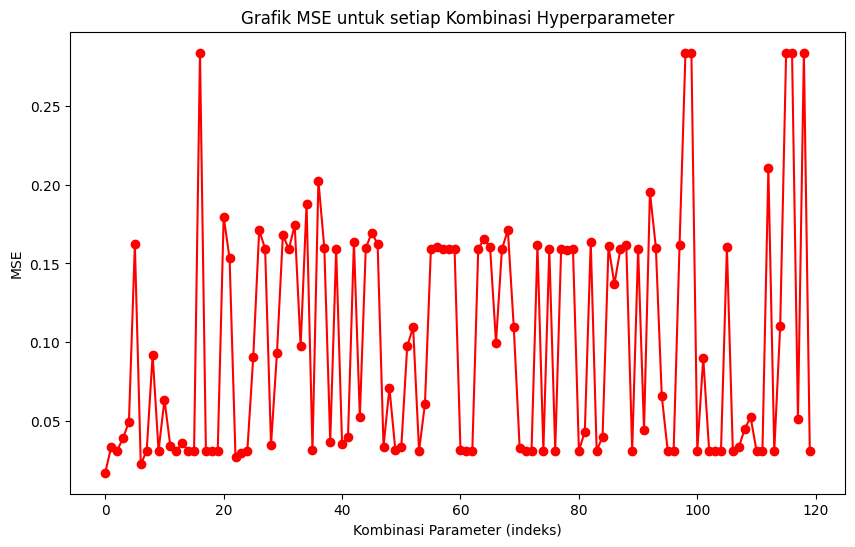

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(tuning)), tuning['mse'], marker='o', linestyle='-', color='r')
plt.title('Grafik MSE untuk setiap Kombinasi Hyperparameter')
plt.xlabel('Kombinasi Parameter (indeks)')
plt.ylabel('MSE')
plt.show()

In [12]:
tuning.to_csv('hasiltuning.csv', index=False)

In [13]:
tuning

,hidden_layer,hidden_neuron,lr,epoch,mse,bobot,bias,bobot_output,bias_output
0,1,"(1,)",0.005,200,0.017229,"[[[0.900500386662847], [1.284236741391115], [0...",[[2.0848531680878577]],[0.14211545730927239],0.146906
1,1,"(1,)",0.005,500,0.033537,"[[[-9.336676025560775], [-9.457850376782197], ...",[[-18.75568693779291]],[0.7388468999256328],0.552358
2,1,"(1,)",0.010,200,0.031209,"[[[-11.614514740383015], [-12.443724754812687]...",[[-23.734769671520368]],[0.6022787075714181],0.504468
3,1,"(1,)",0.010,500,0.039151,"[[[1.2649883585993442], [1.5342032867158395], ...",[[1.7616329939663136]],[0.04542544966577013],0.582848
4,1,"(2,)",0.005,200,0.049582,"[[[1.1494409657644402, -4.073123860450511], [1...","[[0.9752676139557656, -7.44729241820372]]","[0.055290730077733295, 0.32829318066341495]",0.603867
...,...,...,...,...,...,...,...,...,...
115,2,"(5, 4)",0.010,500,0.283749,"[[[-268.03808928133685, -71.62990742921285, -2...","[[0.3050955067818566, 0.7834863029153335, 0.97...","[-0.2596722569530775, -0.5936442173636902, -0....",0.385543
116,2,"(5, 5)",0.005,200,0.283749,"[[[-382.5818547309713, -250.81762377660178, -3...","[[0.7842615043066656, 0.8333082022175051, 0.73...","[-0.08040061918120323, 0.030685725895066795, 0...",0.214162
117,2,"(5, 5)",0.005,500,0.051326,"[[[-179.31725703426665, -647.5967903112024, -4...","[[0.9381344415461729, 0.9485062834428353, 0.78...","[0.4583477718373244, 0.545824336342713, -0.036...",0.242132
118,2,"(5, 5)",0.010,200,0.283749,"[[[-400.40174988702336, -519.0653039996396, -2...","[[0.3908866509215785, 0.8175271920240975, 0.89...","[-0.5122709338076891, -0.14981040612456087, -1...",0.678286


In [14]:
best_index = tuning['mse'].idxmin()
best_hidden_layer_global = tuning['hidden_layer'][best_index]
best_hidden_neuron_global = tuning['hidden_neuron'][best_index]
best_lr_global = tuning['lr'][best_index]
best_epoch_global = tuning['epoch'][best_index]
best_mse_global = tuning['mse'][best_index]
best_bobot_global = tuning['bobot'][best_index]
best_bias_global = tuning['bias'][best_index]
best_bobot_output_global = tuning['bobot_output'][best_index]
best_bias_output_global = tuning['bias_output'][best_index]

print("Best Index:", best_index)
print("Best Hidden Layer:", best_hidden_layer_global)
print("Best Hidden Neuron:", best_hidden_neuron_global)
print("Best Learning Rate:", best_lr_global)
print("Best Epoch:", best_epoch_global)
print("Best MSE:", best_mse_global)
print("Best Bobot:", best_bobot_global)
print("Best Bias:", best_bias_global)
print("Best Bobot Output:", best_bobot_output_global)
print("Best Bias Output:", best_bias_output_global)

Best Index: 0
Best Hidden Layer: 1
Best Hidden Neuron: (1,)
Best Learning Rate: 0.005
Best Epoch: 200
Best MSE: 0.017229195090248707
Best Bobot: [[[np.float64(0.900500386662847)], [np.float64(1.284236741391115)], [np.float64(0.7023208742543305)], [np.float64(0.7610398449479346)]]]
Best Bias: [[np.float64(2.0848531680878577)]]
Best Bobot Output: [np.float64(0.14211545730927239)]
Best Bias Output: 0.14690566444883998


### Prediksi X_test

##### Data testing

In [15]:
X_test

array([[0.38378825, 0.61269841, 0.81711409, 0.47212601],
       [0.45354287, 0.33650794, 0.30033557, 0.63153554],
       [0.4902123 , 0.55111111, 0.72986577, 0.51327726],
       ...,
       [0.67080232, 0.86730159, 0.81711409, 0.94779812],
       [0.68265784, 0.72126984, 0.54362416, 0.6306284 ],
       [0.3046595 , 0.46857143, 0.47651007, 0.24863929]])

##### Fungsi prediksi X_test

In [16]:
def predict(X_test, bobot, bias, bobot_output, bias_output):
    prediksi = []
    for i in range(len(X_test)):
        # FEEDFORWARD
        # Operasi pada Hidden Layer
        aktivasi_hidden = []
        for j in range(len(bobot)):  # untuk setiap hidden layer
            aktivasi_hidden_temp = []
            for k in range(len(bobot[j][0])):  # jumlah neuron di hidden layer
                sumXbobot = 0
                if j == 0:  # layer pertama
                    for l in range(4):  # jumlah neuron input
                        sumXbobot += bobot[j][l][k] * X_test[i][l]
                else:
                    for l in range(len(aktivasi_hidden[j - 1])):
                        sumXbobot += bobot[j][l][k] * aktivasi_hidden[j - 1][l]
                sumXbobotbias = bias[j][k] + sumXbobot
                aktivasi_hidden_temp.append(relu(sumXbobotbias))
            aktivasi_hidden.append(aktivasi_hidden_temp)

        # Operasi pada Output Layer
        sumZbobotoutput = 0
        for j in range(len(aktivasi_hidden[-1])):
            sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
        sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
        predik = relu(sumZbobotoutput_biasoutput)
        prediksi.append(predik)

    return prediksi

##### Pemanggilan fungsi prediksi

In [17]:
prediksi = predict(X_test, best_bobot_global, best_bias_global, best_bobot_output_global, best_bias_output_global)

##### Visualisasi hasil prediksi dan aktual

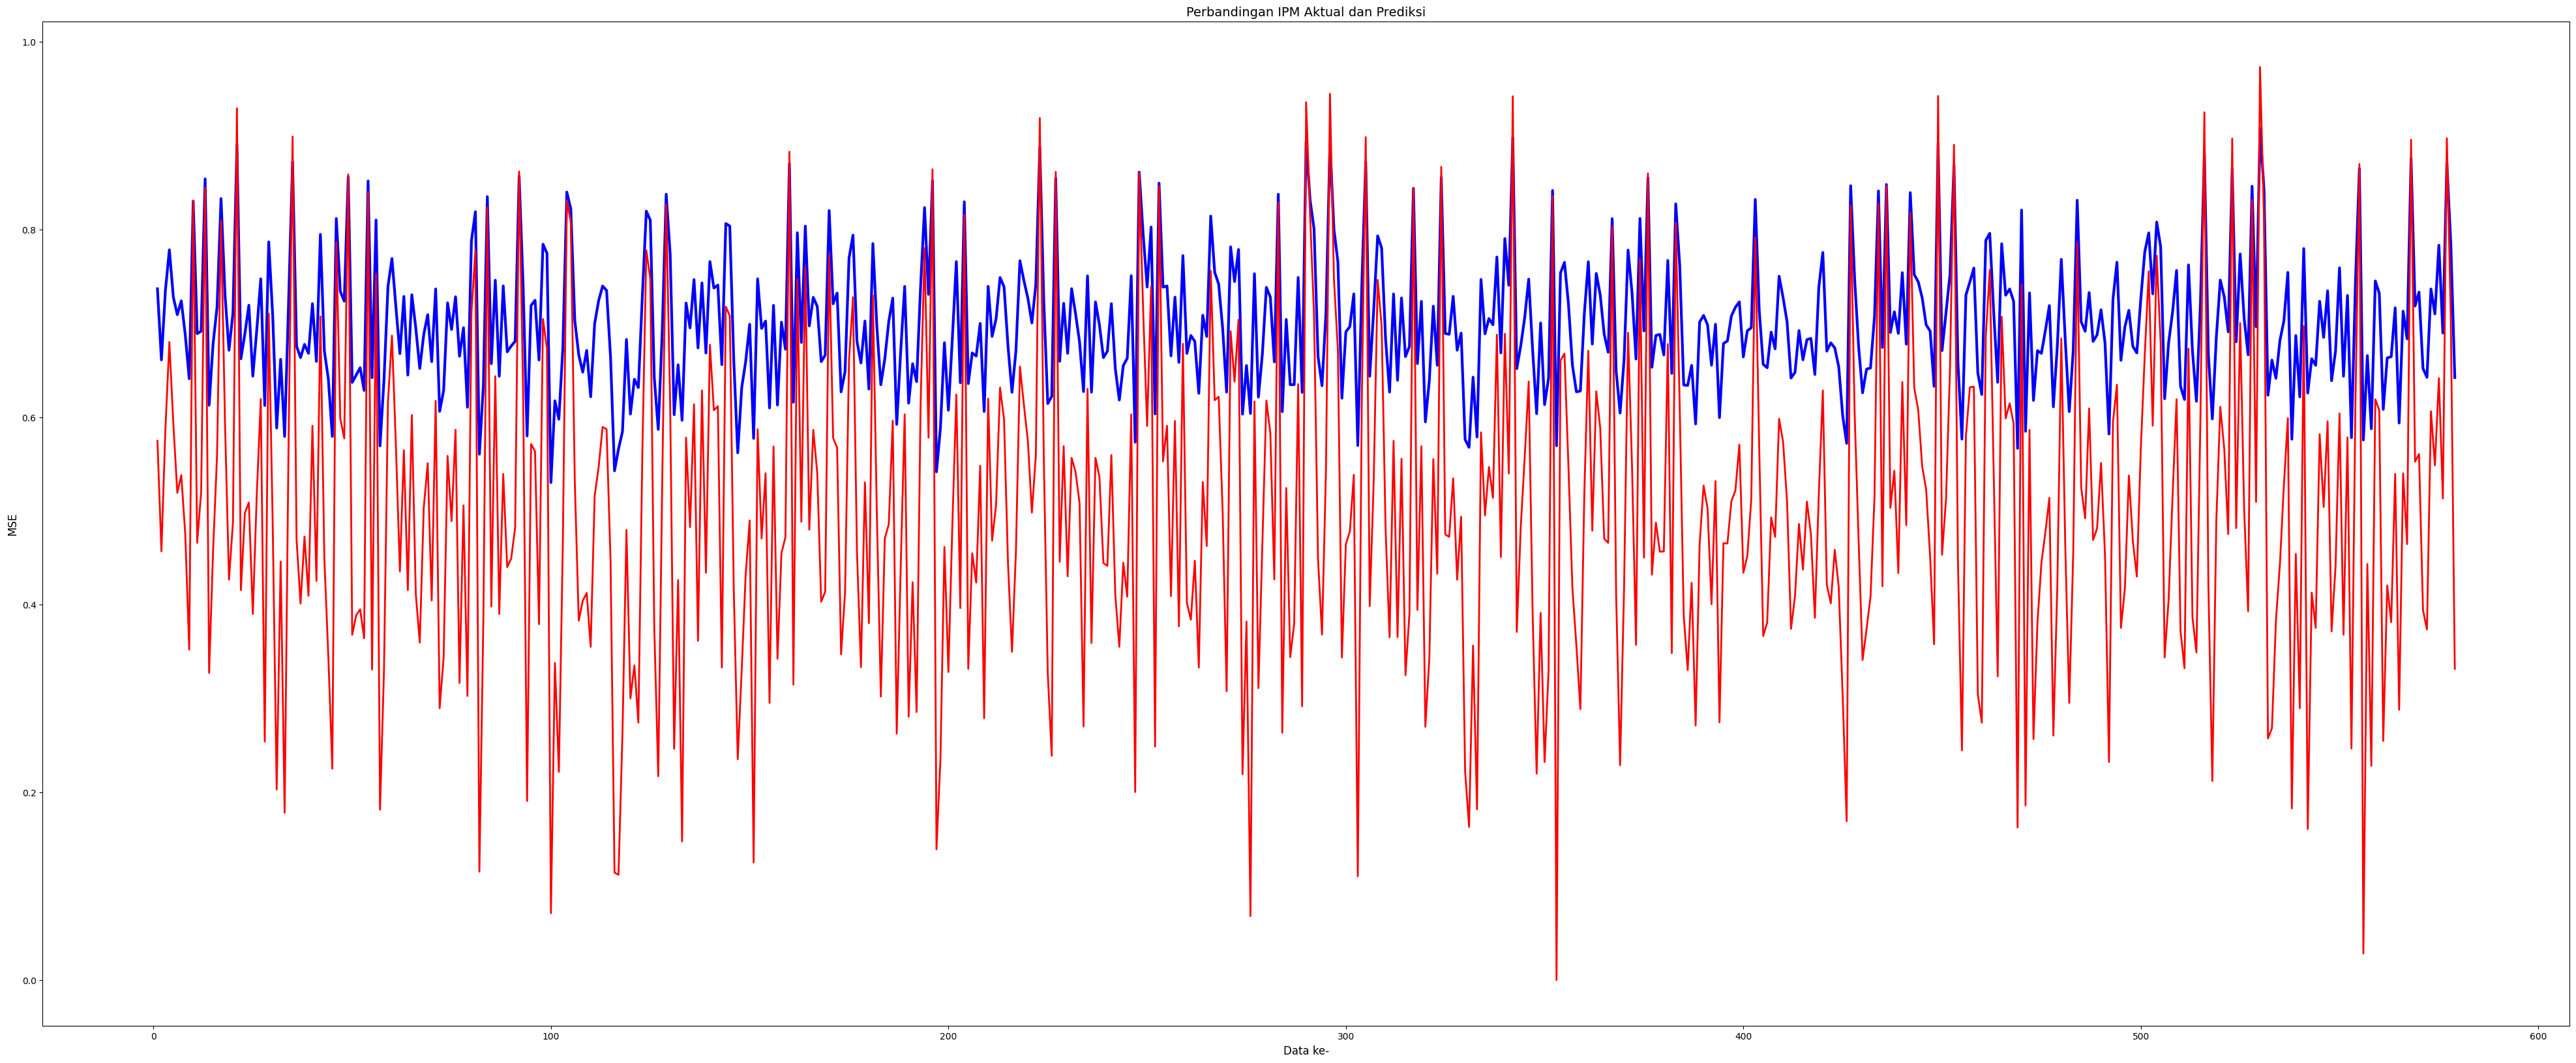

In [18]:
datake = list(range(1, len(y_test)+1))
plt.figure(figsize=(50, 20))
plt.plot(datake, prediksi, label="ipm prediksi", color='blue', linewidth=3)
plt.plot(datake, y_test, label="ipm aktual", color='red', linewidth=2)
plt.title('Perbandingan IPM Aktual dan Prediksi', fontsize=14)
plt.xlabel('Data ke-', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.show()

In [19]:
for i in range(len(y_test)):
    print(f"Aktual: {y_test[i][0]} - Prediksi: {prediksi[i]}")

Aktual: 0.574689493118496 - Prediksi: 0.7367540855133932
Aktual: 0.4568647197045989 - Prediksi: 0.6609344609052759
Aktual: 0.586774085263511 - Prediksi: 0.7348758357303711
Aktual: 0.6800939912722388 - Prediksi: 0.7782689172135865
Aktual: 0.5928163813360188 - Prediksi: 0.727763664576157
Aktual: 0.5193017791205103 - Prediksi: 0.7091294263326342
Aktual: 0.5381000335683113 - Prediksi: 0.7239202476748843
Aktual: 0.4749916079221212 - Prediksi: 0.6876494779268519
Aktual: 0.3521315877811348 - Prediksi: 0.6408774318713395
Aktual: 0.8308157099697886 - Prediksi: 0.8301769933351444
Aktual: 0.4659281638133601 - Prediksi: 0.6888939735366588
Aktual: 0.5206445115810676 - Prediksi: 0.6915586691081719
Aktual: 0.8445787176905002 - Prediksi: 0.8539346144133892
Aktual: 0.3272910372608257 - Prediksi: 0.6126180749248895
Aktual: 0.4578717690500169 - Prediksi: 0.6781386047738059
Aktual: 0.5592480698220879 - Prediksi: 0.7172770205402772
Aktual: 0.8093319906008731 - Prediksi: 0.8329302123677214
Aktual: 0.5934877

### Prediksi Data Baru

##### Fungsi prediksi data baru

In [20]:
def predict(X_new, bobot, bias, bobot_output, bias_output):
    prediksi = []
    for i in range(len(X_new)):
        # FEEDFORWARD
        # Operasi pada Hidden Layer
        aktivasi_hidden = []
        for j in range(len(bobot)):  # untuk setiap hidden layer
            aktivasi_hidden_temp = []
            for k in range(len(bobot[j][0])):  # jumlah neuron di hidden layer
                sumXbobot = 0
                if j == 0:  # layer pertama
                    for l in range(4):  # jumlah neuron input
                        sumXbobot += bobot[j][l][k] * X_new[i][l]
                else:
                    for l in range(len(aktivasi_hidden[j - 1])):
                        sumXbobot += bobot[j][l][k] * aktivasi_hidden[j - 1][l]
                sumXbobotbias = bias[j][k] + sumXbobot
                aktivasi_hidden_temp.append(relu(sumXbobotbias))
            aktivasi_hidden.append(aktivasi_hidden_temp)

        # Operasi pada Output Layer
        sumZbobotoutput = 0
        for j in range(len(aktivasi_hidden[-1])):
            sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
        sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
        predik = relu(sumZbobotoutput_biasoutput)
        prediksi.append(predik)

    return prediksi

##### Contoh prediksi

In [21]:
# angka_harapan_hidup, rerata_lama_sekolah, harapan_lama_sekolah, pengeluaran_per_kapita
X_new = [[65.655, 9.76, 14.28, 7686]]

scaler_fitur = joblib.load('fitur_mmscaler_model.pkl')
X_new_scaled = scaler_fitur.transform(X_new)

hasil_prediksi = predict(X_new_scaled, best_bobot_global, best_bias_global, best_bobot_output_global, best_bias_output_global)

scaler_target = joblib.load('target_mmscaler_y.pkl')
y_pred_original = scaler_target.inverse_transform([[hasil_prediksi[0]]])
print(y_pred_original)

[[74.95141573]]


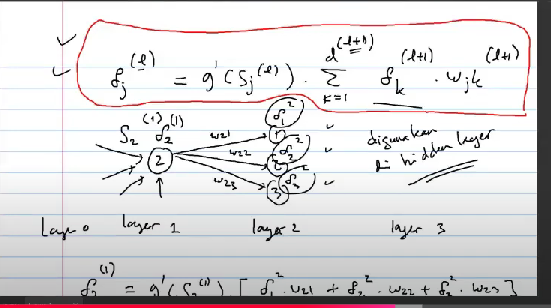

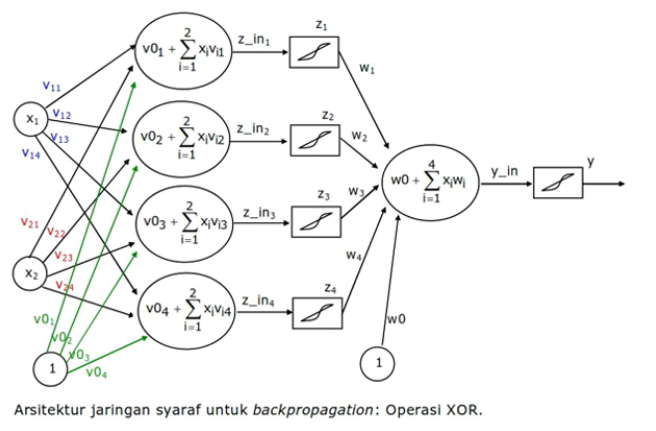